<a href="https://colab.research.google.com/github/fsommers/ICMR24/blob/main/ICMR24_LayoutLMv3_1_DataProcessorAndDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore a Custom Document Dataset with the LayoutLMv3 Processor

This example assumes that the custom document images are stored on Google Drive, in a `DOC_EXAMPLES/TRAINING` subdirectory.

For each document label, there is a corresponding subdirectory named as the document label. Currently, there are 8 labels:

* AZCONTRACT
* BOOKSHEET
* BUYERSGUIDE
* CACONTRACT
* CREDITAPP
* INSURANCE
* NVCONTRACT
* OTHER (not used now)

In each directory there are PDF documents.

The goal is to build model that can classify unseen documents into any of these categories 8 categories.

The LayoutLMv3 model requires the following input for each example:

* The sequence of words on the page.
* The bounding box of each word. For each word, there must be a corresponding bounding box. That means the length of the bounding boxes list must be the same as the length of the list of words.
* The image of the page itself.

In addition, the LayoutLM family of models requires that we normalize the bounding box coordinates to an image size of 1000.

For this example, we will let the first page of each PDF determine the type of the document.

Therefore, the first task is to obtain the first page of the PDF as an image. Since PDFs can contain both images as well as display instructions ("non-image PDF"), we will need to render the first page as an image at a given resolution (e.g., 300dpi):

In [33]:
import sys
from pathlib import Path
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = Path('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING')

DOCUMENT_LABELS = [
    'AZCONTRACT',
    'BOOKSHEET',
    'BUYERSGUIDE',
    'CACONTRACT',
    'CREDITAPP',
    'INSURANCE'
]

labels_dirs = { doc_label: BASE_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(labels_dirs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'AZCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/AZCONTRACT'), 'BOOKSHEET': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/BOOKSHEET'), 'BUYERSGUIDE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/BUYERSGUIDE'), 'CACONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/CACONTRACT'), 'CREDITAPP': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/CREDITAPP'), 'INSURANCE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/INSURANCE')}


Let's have a look at one of these images:

In [ ]:
!pip install -qqq PyMuPDF

In [ ]:
az_contracts = list(labels_dirs['AZCONTRACT'].glob('*.pdf'))

import fitz
import numpy as np
from PIL import Image, ImageDraw, ImageFont


pdf = fitz.open(az_contracts[0])
pix = pdf.get_page_pixmap(0, dpi=300)
# The rendered page pixmap returned from PyMuPDF is a 1-dimensional array. However, most image processing libraries
# require a 3-dim array format where each pixel is represented by 3 values (r, g, b) for color images.
# reshape() transforms the 1-dimensional array to a 3-dim array:
# pix.height rows
# pix.width columns
# 3 channels
image = np.frombuffer(pix.samples, dtype=np.uint8)
image = image.reshape((pix.height, pix.width, 3))
image = Image.fromarray(image)
image

LayoutLMv3 relies on an external OCR process to obtain the page's word sequence as well as the sequence of word bounding boxes.

LayoutLMv3 conveniently comes with a processor that can consume the image and construct a training example using the Tesseract OCR library under the hood.

The OCR process can take a while to run on each page, and in practice it's more effective to cache the OCR output on disk. But for now, let's run the `LayoutLMv3Processor` on the above image. The Processor consumes a feature extractor and the tokenizer.

Since the pretrained LayoutLMv3 model uses RoBERTa for the initial model weights for the text modality, we must follow RoBERTa's sequence length and truncate the text at 512 tokens. This could problems for longer documents, of course. However, for many business-type documents, this works out in practice, as the first few hundred tokens sufficiently describe the page. We ask the processor to return PyTorch tensors:

In [ ]:
! apt -qq install tesseract-ocr
! apt -qq install libtesseract-dev

In [ ]:
!pip install -qqq pytesseract
!pip install -qqq Pillow

In [ ]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification

feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True, ocr_lang="eng") # Apply the OCR under the hood
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

encoding = processor(
    image,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

The processor produced a dictionary with these keys:

* `input_ids`: The words in tokenized format.
* `attention_mask`
* `bbox`: Each element contains 4 values (left, top, right, bottom).
* `pixel_values`: For the image embedding. 224x224 squares, 3 channels


In [ ]:
print(f"""
 input_ids: {list(encoding["input_ids"].squeeze().shape)}
 word boxes: {list(encoding['bbox'].squeeze().shape)}
 image data: {list(encoding['pixel_values'].squeeze().shape)}
 image size: {image.size}
""")


 input_ids: [512]
 word boxes: [512, 4]
 image data: [3, 224, 224]
 image size: (2540, 4244)



We can peak into the FeatureExtractor to get an insight of how it converts the provided image into the words and bounding boxes.

`image_mean` and `image_std` are used for the image normalization.

In [ ]:
feature_extractor

LayoutLMv3FeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "apply_ocr",
    "ocr_lang",
    "tesseract_config",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "apply_ocr": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3FeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": "eng",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

In [ ]:
features = feature_extractor(image)
print(features.keys())

print(f"""
 image size: {features["pixel_values"][0].shape}
 word count: {(len(features["words"][0]))}
 word boxes: {len(features["boxes"][0])}
""")

print(features["boxes"][0][:5]) # the first 5 words

print(features["words"][0][:5]) # The first 5 corresponding bounding boxes

dict_keys(['pixel_values', 'words', 'boxes'])

 image size: (3, 224, 224)
 word count: 1096
 word boxes: 1096

[[212, 16, 301, 31], [312, 16, 678, 35], [694, 16, 789, 32], [225, 46, 282, 53], [288, 46, 401, 54]]
['AAW', '553-AZ-ARB-eps-14', '11/23', 'RETAIL', 'INSTALLMENT']


We can also take a look at how the model sees the image:

(3, 224, 224)
(224, 224, 3)
[1. 1. 1.]
[255 255 255]


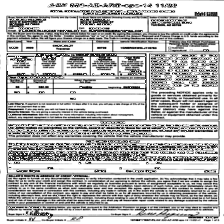

In [ ]:
image_data = features["pixel_values"][0]
print(image_data.shape)

# Transpose and put the image channels at the back
image_data = image_data.transpose(1, 2, 0)
print(image_data.shape)

# This array is floats, to display it we need to convert it to integers ranging from 0 to 255
print(image_data[0][0])

image_data = np.uint8(image_data * 255)
print(image_data[0][0])

Image.fromarray(image_data, mode='RGB')


We can display the OCR bounding boxes on the image:


In [ ]:
bounding_boxes = features["boxes"][0]
words = features["words"][0]

az_contracts = list(labels_dirs['AZCONTRACT'].glob('*.pdf'))

from PIL import Image, ImageDraw, ImageFont

pdf = fitz.open(az_contracts[0])
pix = pdf.get_page_pixmap(0, dpi=300)
image = np.frombuffer(pix.samples, dtype=np.uint8)
image = image.reshape((pix.height, pix.width, 3))
image = Image.fromarray(image)

width_scale = image.width / 1000
height_scale = image.height / 1000

draw = ImageDraw.Draw(image)

for bbox in bounding_boxes:
  draw.rectangle(
      [
          bbox[0] * width_scale,
          bbox[1] * height_scale,
          bbox[2] * width_scale,
          bbox[3] * height_scale,
      ],
      outline='blue',
      width=2
  )
image

Finally, let's take a look at the `LayoutLMv3Tokenizer`. We can see that vocabulary size is 50265 and the max sequence length is 512, both of which come from RoBERTa, as do the special tokens:

In [ ]:
print(tokenizer)

LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}


In [ ]:
encoding = tokenizer(
    text=words,
    boxes=bounding_boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

print(encoding.keys())

tokens = tokenizer.convert_ids_to_tokens(
    encoding["input_ids"][0],
    skip_special_tokens=True
)
print(tokens[:20]) # The first 20 tokens

dict_keys(['input_ids', 'attention_mask', 'bbox'])
['ĠA', 'AW', 'Ġ5', '53', '-', 'AZ', '-', 'ARB', '-', 'eps', '-', '14', 'Ġ11', '/', '23', 'ĠR', 'ETA', 'IL', 'ĠINST', 'ALL']


We can convert these tokens back to strings to see what the first 20 tokens look like:

In [ ]:
tokenizer.convert_tokens_to_string(tokens[:20])

' AAW 553-AZ-ARB-eps-14 11/23 RETAIL INSTALL'

## Passing an Example to the Model

Having explored the Processor and the Tokenizer, let's now pass an example to the model and see the model's output. We load the model so that we can take a look at the last hidden state once we process the example:

In [ ]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base", output_hidden_states=True)

print(model.config)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv3",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "patch_size": 16,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "second_input_size": 112,
  "shape_size": 128,
  "text_embed": true,
  "torch_dtype": "float32",
  "transformers_version": "4.41.1",
  "type_vocab_size": 1,
  "visual_embed": true,
  "vocab

We see that the LayoutLMv3BASE model contains 12 hidden layers.

In [ ]:
encoding = processor(
    image,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
outputs = model(**encoding)
print(outputs)

Hidden states is a list of tensors. Each tensor represents the hidden state at a specific layer.

The last hidden state is often used as a representation of the input.
It's common to use it as the input to a classification head or other downstream tasks.

Let's take a look at the last hidden state tensor:

In [ ]:
last_hidden_state = outputs.hidden_states[-1]
print(last_hidden_state)

tensor([[[-0.1382, -0.0150, -0.3747,  ..., -0.3055, -0.1702,  0.1277],
         [-0.1468, -0.0309, -0.1737,  ..., -0.3381, -0.0844,  0.1438],
         [ 0.4533, -0.6463, -0.2152,  ...,  0.4620, -0.4765, -0.1901],
         ...,
         [ 0.0653,  0.2503,  0.0578,  ..., -0.4706, -0.0636,  0.1991],
         [ 0.0963,  0.2337, -0.1197,  ..., -0.4955, -0.1598, -0.1202],
         [-0.1101,  0.3288,  0.1093,  ..., -0.3181,  0.0400, -0.3739]]],
       grad_fn=<NativeLayerNormBackward0>)


Finally, let's take a look at the raw logits of the output:

In [ ]:
outputs.logits

tensor([[ 0.1778, -0.1404]], grad_fn=<AddmmBackward0>)

This model only has 2 classes. This makes sense, since the model doesn't know our data.